In [1]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy.stats import ks_2samp, mannwhitneyu, wasserstein_distance, norm
from pathlib import Path
from datasets import load_dataset

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

# Configure visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


# Training Dataset vs VAE-Generated Tags Comparison

This notebook compares the original training dataset with VAE-generated tags dataset to validate the generation quality and assess how well the VAE preserves the statistical properties of the original data.


## Load and Prepare Datasets


In [2]:
df_mc = load_dataset("google/MusicCaps", split="train").to_pandas()
df_mc['aspect_list'] = df_mc['aspect_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

In [3]:
KNOWN_TAGS = json.load(open("../data/concepts_to_tags.json", "r"))

# Reverse map for easy lookup (tag -> category)
TAG_TO_CATEGORY = {}
for cat, tags in KNOWN_TAGS.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat


In [4]:
# Parse tags into categories
def parse_tags(tags):
    # filter out unknown tags
    tags = [t for t in tags if t in TAG_TO_CATEGORY]
    return pd.Series({
        'genre_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'genre'],
        'mood_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'mood'],
        'instrument_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'instrument'],
        'tempo_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'tempo']
    })

In [5]:

# Load VAE-generated dataset
df_vae = pd.read_csv("../data/vae_mtg_tags/all.csv")
df_vae = df_vae.reset_index(drop=True)
df_vae = df_vae.fillna('')

# Parse tag strings and list representations
df_vae['aspect_list'] = df_vae['aspect_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
tag_categories = df_vae['aspect_list'].apply(parse_tags)
df_vae = pd.concat([df_vae, tag_categories], axis=1)

df_mc = df_mc.copy()
tag_categories_mc = df_mc['aspect_list'].apply(parse_tags)
df_mc = pd.concat([df_mc, tag_categories_mc], axis=1)

print("\nVAE-Generated Dataset Loaded")
print(f"  Shape: {df_vae.shape}")
print(f"  Unique temperatures: {df_vae['temperature'].unique()}")
print(f"  Sample row:")
print(df_vae.iloc[0])

print("\nMusicCaps Dataset Loaded")
print(f"  Shape: {df_mc.shape}")
print(f"  Sample row:")
print(df_mc.iloc[0])


VAE-Generated Dataset Loaded
  Shape: (11348, 12)
  Unique temperatures: [1.5 0.5 2.  0.8 1. ]
  Sample row:
aspect_list                  [e-bass, e-guitar, energetic, guitar, pop, upt...
original_aspect_list         ['drums', 'bass', 'guitar', 'rock', 'emotional...
temperature                                                                1.5
generated_tempo_tags                                               ['uptempo']
generated_genre_tags                                                        []
generated_mood_tags                                              ['energetic']
generated_instrument_tags                               ['e-bass', 'e-guitar']
id                                            cef44c2ffbd9d07d2714994d00ac5786
genre_tags                                                               [pop]
mood_tags                                                          [energetic]
instrument_tags                                     [e-bass, e-guitar, guitar]
tempo_tags           

In [6]:

# For easier comparison, focus on a single temperature (use 1.0 as baseline)
df_vae_baseline = df_vae[df_vae['temperature'] == 1.0].reset_index(drop=True)

print(f"\nUsing VAE dataset at temperature=1.0")
print(f"  Shape: {df_vae_baseline.shape}")


Using VAE dataset at temperature=1.0
  Shape: (1884, 12)


## Compute Tag Distribution Statistics


In [7]:

# Define tag categories for comparison
tag_categories = {
    'Tempo': 'tempo_tags',
    'Genre': 'genre_tags',
    'Mood': 'mood_tags',
    'Instrument': 'instrument_tags',
}

# Compute statistics for each category
stats_data = []

for cat_name, col in tag_categories.items():
    train_counts = df_mc[col].apply(len)
    vae_counts = df_vae_baseline[col].apply(len)
    
    stats_data.append({
        'Category': cat_name,
        'Dataset': 'MusicCaps',
        'Mean': train_counts.mean(),
        'Median': train_counts.median(),
        'Std': train_counts.std(),
        'Min': train_counts.min(),
        'Max': train_counts.max(),
        'Q25': train_counts.quantile(0.25),
        'Q75': train_counts.quantile(0.75),
        'Count': len(train_counts)
    })
    
    stats_data.append({
        'Category': cat_name,
        'Dataset': 'VAE-Generated',
        'Mean': vae_counts.mean(),
        'Median': vae_counts.median(),
        'Std': vae_counts.std(),
        'Min': vae_counts.min(),
        'Max': vae_counts.max(),
        'Q25': vae_counts.quantile(0.25),
        'Q75': vae_counts.quantile(0.75),
        'Count': len(vae_counts)
    })

stats_df = pd.DataFrame(stats_data)

print("\n" + "="*100)
print("TAG COUNT STATISTICS COMPARISON")
print("="*100)
print(stats_df.to_string(index=False))



TAG COUNT STATISTICS COMPARISON
  Category       Dataset     Mean  Median      Std  Min  Max  Q25  Q75  Count
     Tempo     MusicCaps 0.605144     0.0 0.743963    0    6  0.0  1.0   5521
     Tempo VAE-Generated 1.355626     1.0 0.684294    1    6  1.0  2.0   1884
     Genre     MusicCaps 0.502626     0.0 0.769695    0    8  0.0  1.0   5521
     Genre VAE-Generated 1.406051     1.0 0.700645    1    6  1.0  2.0   1884
      Mood     MusicCaps 0.984423     1.0 1.235984    0    8  0.0  2.0   5521
      Mood VAE-Generated 1.565817     1.0 0.841325    1    7  1.0  2.0   1884
Instrument     MusicCaps 1.286905     1.0 1.321611    0    6  0.0  2.0   5521
Instrument VAE-Generated 2.077495     2.0 1.037964    1    6  1.0  3.0   1884


## Compare Individual Tag Distributions

Analyze how specific tags (genre, instrument, mood) are distributed in each dataset to assess if VAE generation preserves individual tag frequencies.

In [8]:
# Flatten all tags and count occurrences
from collections import Counter

tag_type_comparisons = []

# Helper function to get all tags from a column
def get_all_tags(df, column):
    all_tags = []
    for tag_list in df[column]:
        all_tags.extend(tag_list)
    return all_tags

# Compare each tag category - using ALL temperatures in VAE dataset
categories_to_compare = [
    ('Genre', 'genre_tags'),
    ('Instrument', 'instrument_tags'),
    ('Mood', 'mood_tags'),
    ('Tempo', 'tempo_tags')
]

tag_comparison_results = {}

df_vae_all = df_vae.reset_index(drop=True)

for cat_name, col_name in categories_to_compare:
    train_tags = get_all_tags(df_mc, col_name)
    vae_tags = get_all_tags(df_vae_all, col_name)
    
    train_counter = Counter(train_tags)
    vae_counter = Counter(vae_tags)
    
    # Get all unique tags
    all_unique_tags = set(train_counter.keys()) | set(vae_counter.keys())
    
    # Create comparison dataframe with percentages
    comparison_data = []
    for tag in sorted(all_unique_tags):
        train_count = train_counter.get(tag, 0)
        vae_count = vae_counter.get(tag, 0)
        train_percentage = (train_count / len(train_tags) * 100) if len(train_tags) > 0 else 0
        vae_percentage = (vae_count / len(vae_tags) * 100) if len(vae_tags) > 0 else 0
        
        comparison_data.append({
            'Tag': tag,
            'MusicCaps Count': train_count,
            'VAE Count': vae_count,
            'MusicCaps %': train_percentage,
            'VAE %': vae_percentage,
            '% Difference': vae_percentage - train_percentage,
            'Count Difference': vae_count - train_count
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    tag_comparison_results[cat_name] = comparison_df.sort_values('Count Difference', ascending=False)
    
    print(f"\n{'='*120}")
    print(f"{cat_name.upper()} TAGS COMPARISON")
    print(f"{'='*120}")
    print(f"Total unique {cat_name.lower()} tags: {len(all_unique_tags)}")
    print(f"MusicCaps dataset - Total {cat_name.lower()} tags: {len(train_tags)}")
    print(f"VAE dataset - Total {cat_name.lower()} tags: {len(vae_tags)}")
    print(f"\nTop 10 tags by count difference:")
    print(comparison_df.sort_values('Count Difference', ascending=False)[['Tag', 'MusicCaps Count', 'VAE Count', 'MusicCaps %', 'VAE %']].head(10).to_string(index=False))
    print(f"\nBottom 10 tags by count difference:")
    print(comparison_df.sort_values('Count Difference', ascending=True)[['Tag', 'MusicCaps Count', 'VAE Count', 'MusicCaps %', 'VAE %']].head(10).to_string(index=False))



GENRE TAGS COMPARISON
Total unique genre tags: 50
MusicCaps dataset - Total genre tags: 2775
VAE dataset - Total genre tags: 15951

Top 10 tags by count difference:
             Tag  MusicCaps Count  VAE Count  MusicCaps %     VAE %
            rock              207       1773     7.459459 11.115291
             pop              199       1755     7.171171 11.002445
       classical              111       1467     4.000000  9.196916
           dance               85       1245     3.063063  7.805153
      electronic               35        881     1.261261  5.523165
       cinematic               56        758     2.018018  4.752053
            folk               63        559     2.270270  3.504482
electronic music              134        543     4.828829  3.404175
         ambient               80        487     2.882883  3.053100
     movie music               35        393     1.261261  2.463795

Bottom 10 tags by count difference:
                   Tag  MusicCaps Count  VAE Coun

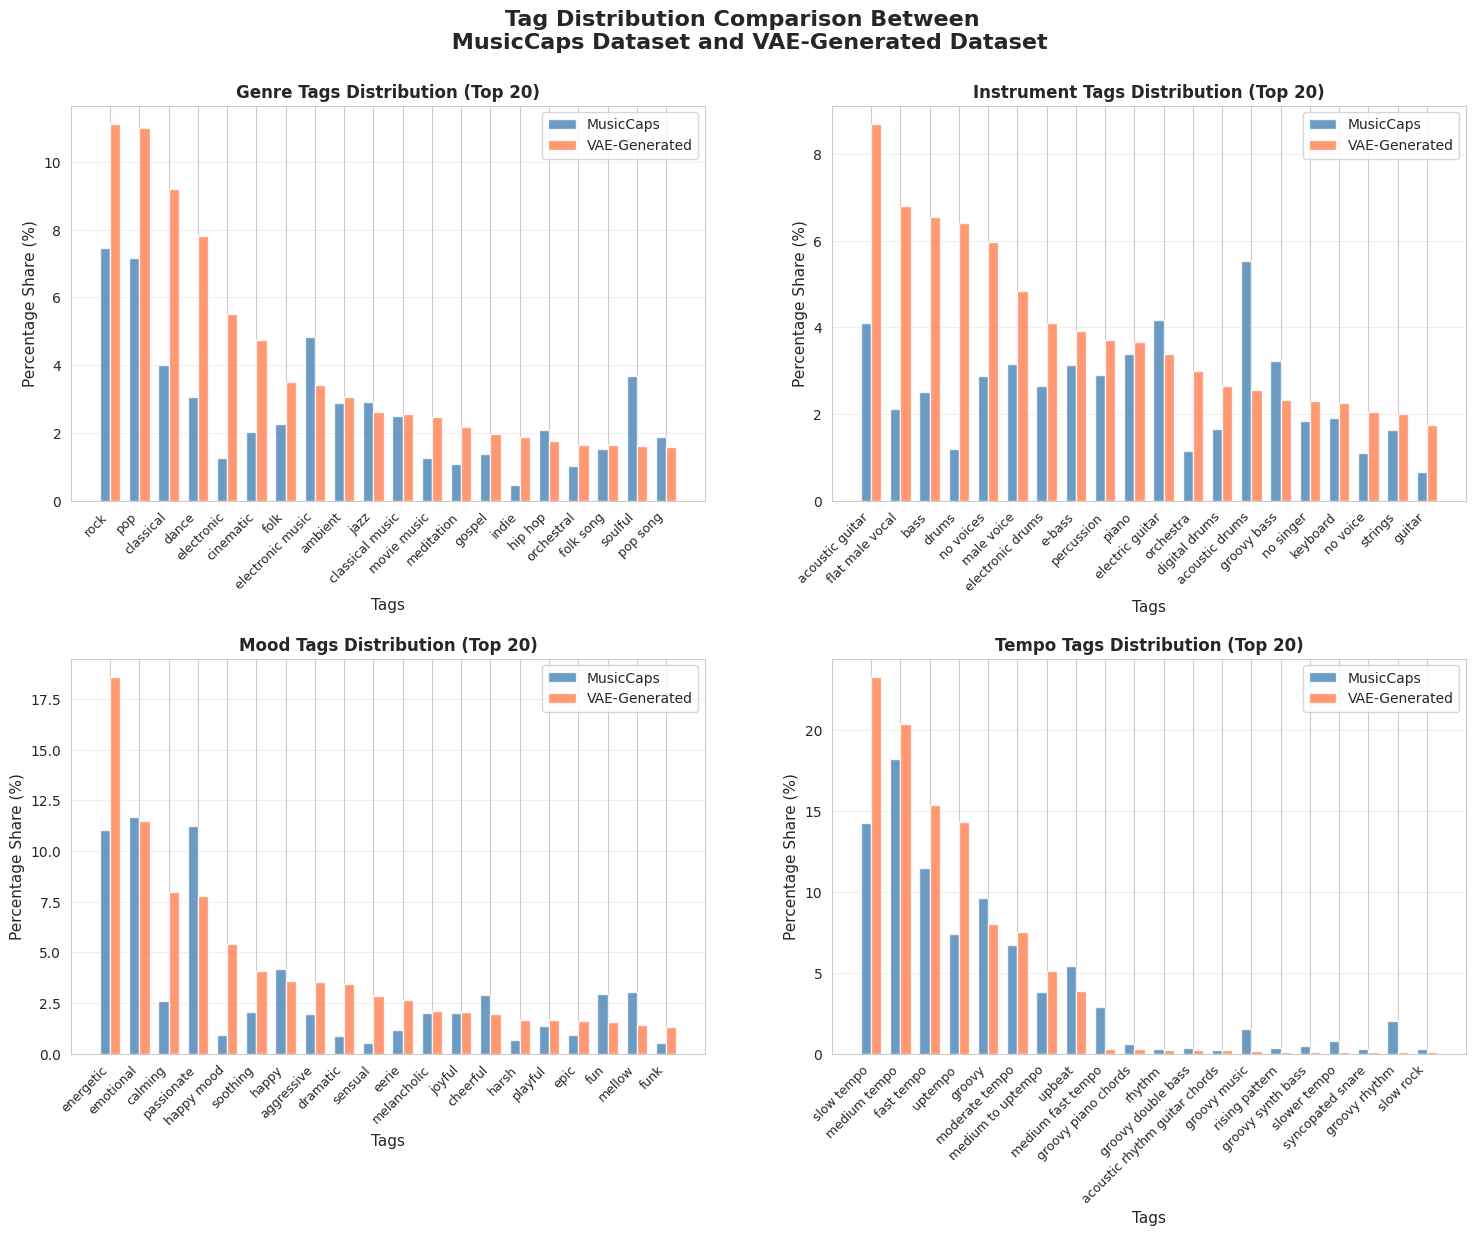

In [9]:
# Create visualizations comparing tag distributions
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    comparison_df = tag_comparison_results[cat_name]
    
    top_tags = comparison_df.nlargest(20, 'VAE Count')
    
    x = np.arange(len(top_tags))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, top_tags['MusicCaps %'], width, label='MusicCaps', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, top_tags['VAE %'], width, label='VAE-Generated', color='coral', alpha=0.8)
    
    ax.set_xlabel('Tags', fontsize=11)
    ax.set_ylabel('Percentage Share (%)', fontsize=11)
    ax.set_title(f'{cat_name} Tags Distribution (Top 20)', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top_tags['Tag'], rotation=45, ha='right', fontsize=9)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Tag Distribution Comparison Between \n MusicCaps Dataset and VAE-Generated Dataset', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

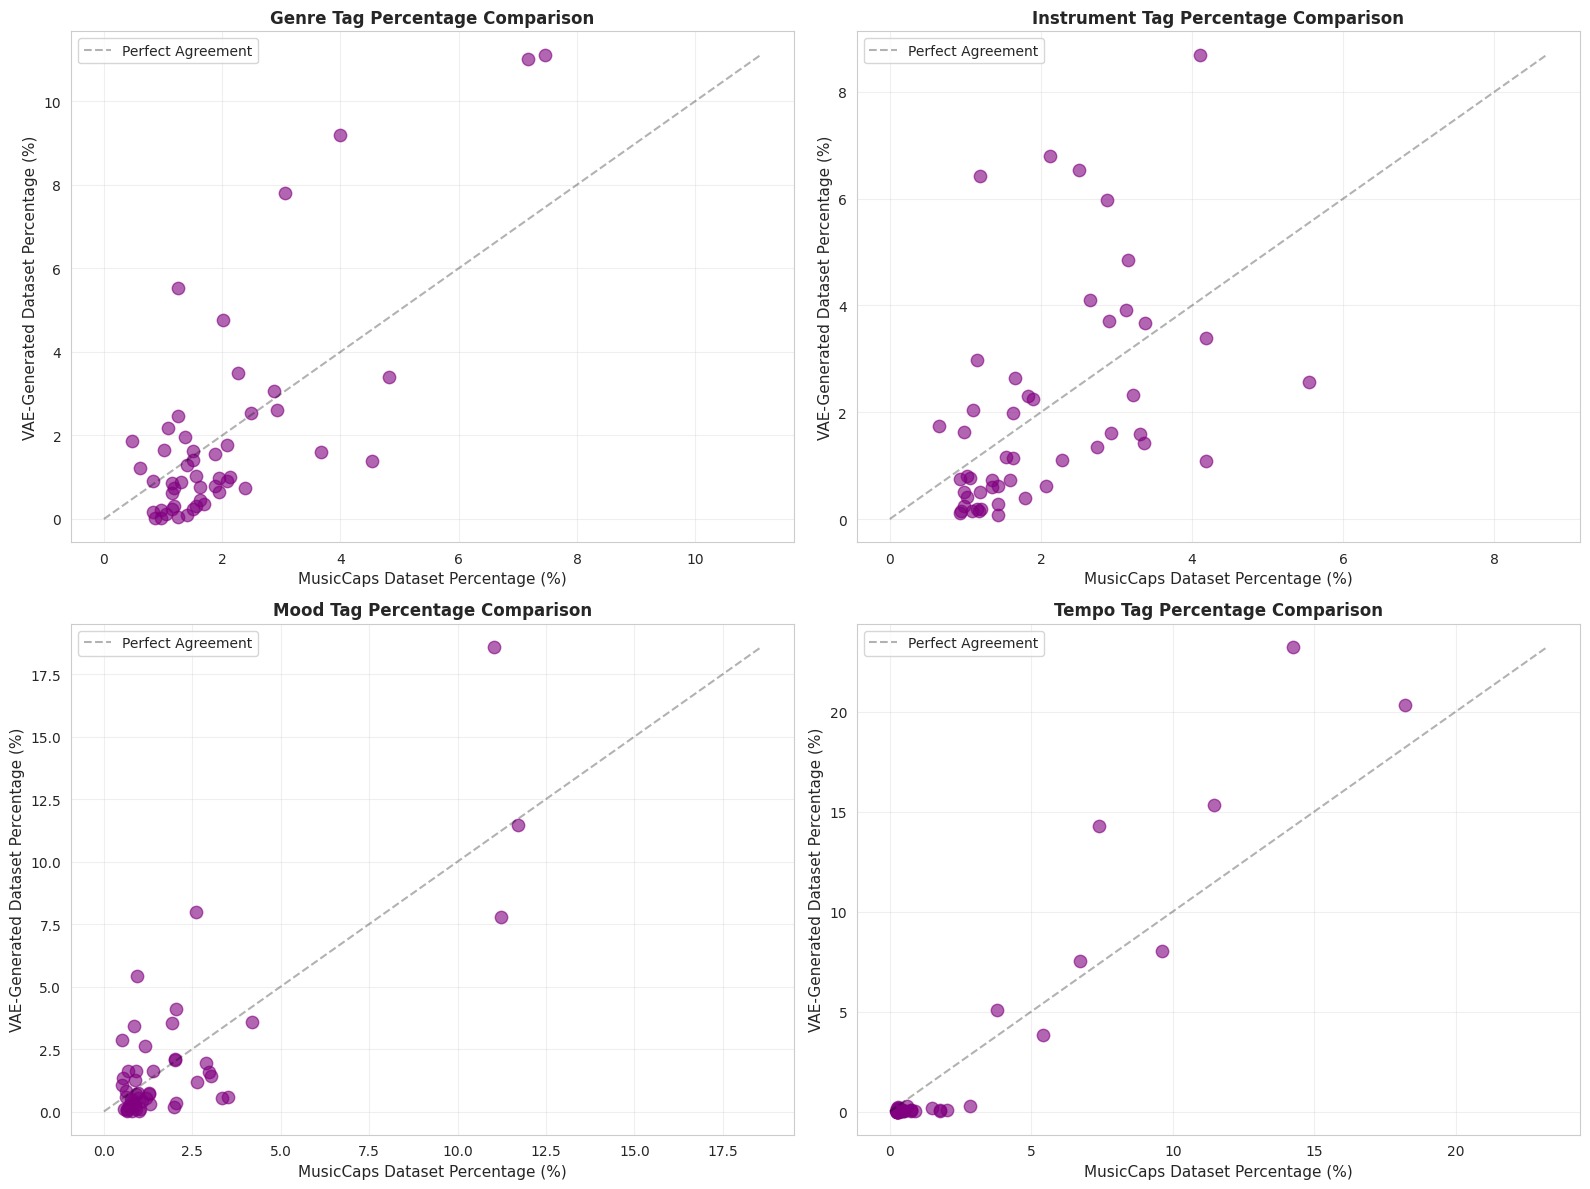


INDIVIDUAL TAG DISTRIBUTION STATISTICAL SUMMARY (Percentage Shares)
  Category  Mean Absolute % Diff  Max Absolute % Diff  Percentage Correlation  Unique Tags
     Genre              1.264595             5.196916                0.774650           50
Instrument              1.333023             5.224116                0.487627           50
      Mood              1.254567             7.564904                0.815458           50
     Tempo              0.959049             8.981474                0.959149           50

INTERPRETATION

The plots above compare how individual tags are distributed in MusicCaps vs VAE-generated data (as % share):
- Points close to the diagonal line indicate similar tag percentages between datasets
- Percentage Correlation > 0.9 suggests excellent preservation of tag distribution patterns
- Mean Absolute % Difference indicates average deviation in tag percentages

If most points cluster near the diagonal, the VAE successfully preserves individual tag distrib

In [10]:
# Statistical comparison using percentage distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

statistical_summary = []

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    comparison_df = tag_comparison_results[cat_name]
    
    # Plot percentage scatter
    ax.scatter(comparison_df['MusicCaps %'], comparison_df['VAE %'], alpha=0.6, s=80, color='purple')
    
    # Add diagonal reference line (perfect agreement)
    max_pct = max(comparison_df['MusicCaps %'].max(), comparison_df['VAE %'].max())
    ax.plot([0, max_pct], [0, max_pct], 'k--', alpha=0.3, label='Perfect Agreement')
    
    ax.set_xlabel('MusicCaps Dataset Percentage (%)', fontsize=11)
    ax.set_ylabel('VAE-Generated Dataset Percentage (%)', fontsize=11)
    ax.set_title(f'{cat_name} Tag Percentage Comparison', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calculate statistics
    mae = (comparison_df['% Difference'].abs()).mean()
    max_diff = comparison_df['% Difference'].abs().max()
    corr = comparison_df['MusicCaps %'].corr(comparison_df['VAE %'])
    
    statistical_summary.append({
        'Category': cat_name,
        'Mean Absolute % Diff': mae,
        'Max Absolute % Diff': max_diff,
        'Percentage Correlation': corr,
        'Unique Tags': len(comparison_df)
    })

plt.tight_layout()
plt.show()

# Print statistical summary
summary_df = pd.DataFrame(statistical_summary)
print("\n" + "="*100)
print("INDIVIDUAL TAG DISTRIBUTION STATISTICAL SUMMARY (Percentage Shares)")
print("="*100)
print(summary_df.to_string(index=False))

# Calculate overall similarity
print("\n" + "="*100)
print("INTERPRETATION")
print("="*100)
print("\nThe plots above compare how individual tags are distributed in MusicCaps vs VAE-generated data (as % share):")
print("- Points close to the diagonal line indicate similar tag percentages between datasets")
print("- Percentage Correlation > 0.9 suggests excellent preservation of tag distribution patterns")
print("- Mean Absolute % Difference indicates average deviation in tag percentages")
print("\nIf most points cluster near the diagonal, the VAE successfully preserves individual tag distributions.")


## Compare Category-wise Tag Counts


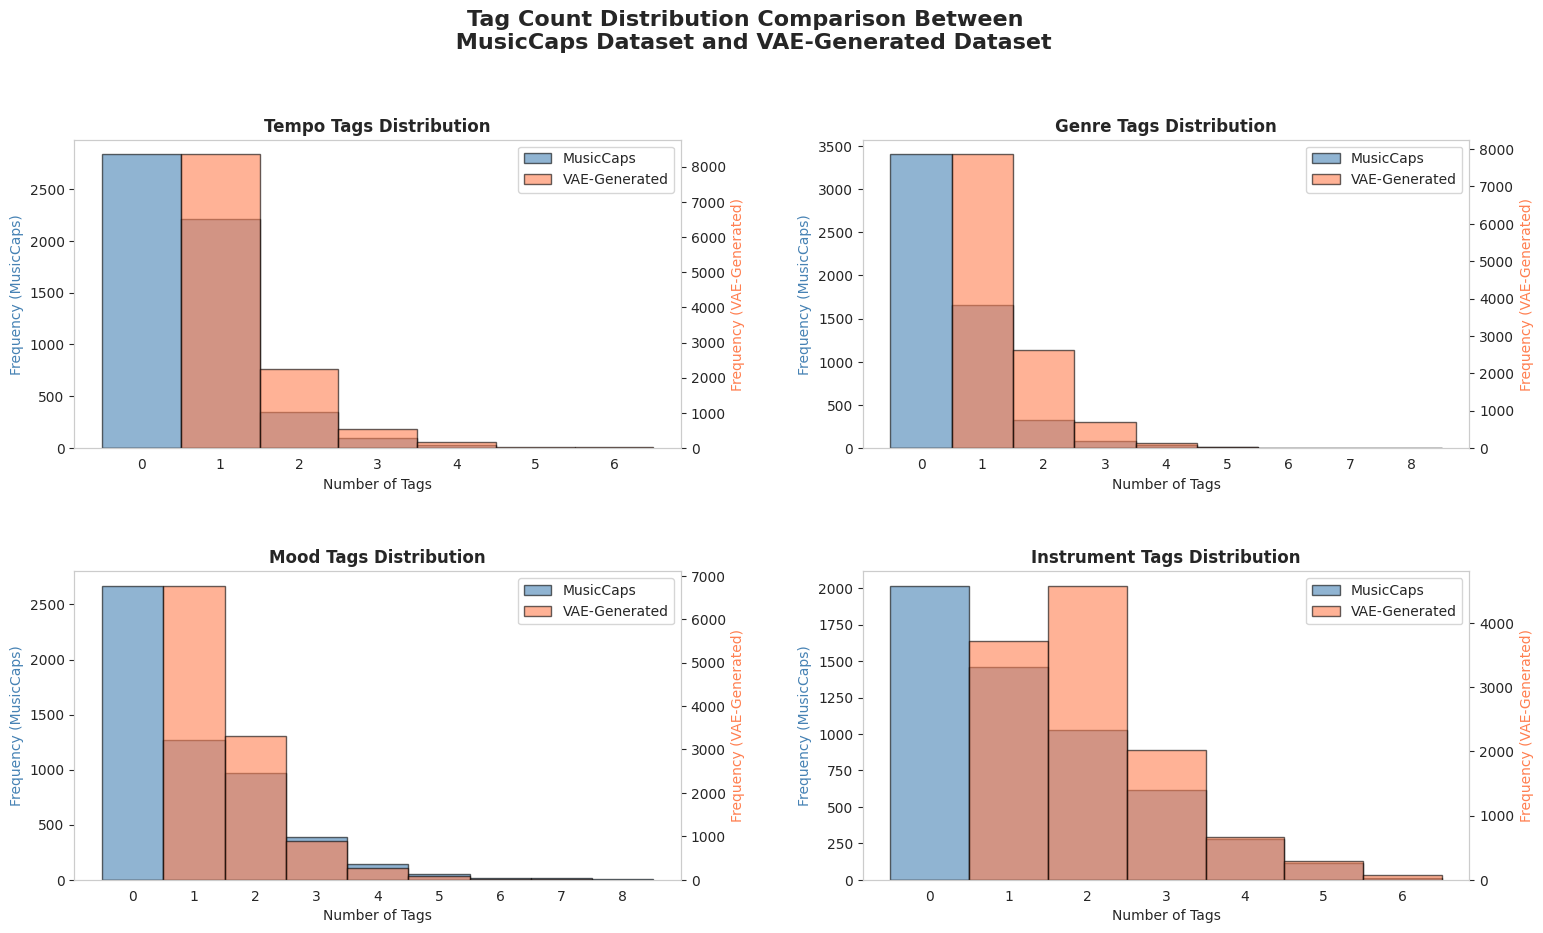

In [11]:
# Create side-by-side distribution plots
fig, axes = plt.subplots(2, len(tag_categories) // 2, figsize=(18, 10))
axes = axes.flatten()

for idx, (cat_name, col) in enumerate(tag_categories.items()):
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    train_counts = df_mc[col].apply(len)
    vae_counts = df_vae_all[col].apply(len)
    
    # Create bins
    max_count = max(train_counts.max(), vae_counts.max())
    bins = np.arange(0, max_count + 2)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot histograms
    n1, _, patches1 = ax1.hist(train_counts, bins=bins, alpha=0.6, label='MusicCaps', color='steelblue', edgecolor='black')
    n2, _, patches2 = ax2.hist(vae_counts, bins=bins, alpha=0.6, label='VAE-Generated', color='coral', edgecolor='black')
    
    # Center x-axis labels to bars
    ax1.set_xticks(bin_centers)
    ax1.set_xticklabels([int(x) for x in bin_centers], rotation=0)
    
    ax1.set_xlabel('Number of Tags')
    ax1.set_ylabel('Frequency (MusicCaps)', color='steelblue')
    ax2.set_ylabel('Frequency (VAE-Generated)', color='coral')
    ax1.set_title(f'{cat_name} Tags Distribution', fontsize=12, fontweight='bold')
    
    handles = [patches1[0], patches2[0]]
    labels = ['MusicCaps', 'VAE-Generated']

    ax1.grid(False)
    ax2.grid(False)
    ax1.legend(handles, labels, loc='upper right')

fig.suptitle('Tag Count Distribution Comparison Between \n MusicCaps Dataset and VAE-Generated Dataset', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.85, hspace=0.4, wspace=0.3)
plt.show()

/tmp/ipykernel_50393/3211103990.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
/tmp/ipykernel_50393/3211103990.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
/tmp/ipykernel_50393/3211103990.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
/tmp/ipykernel_50393/3211103990.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has 

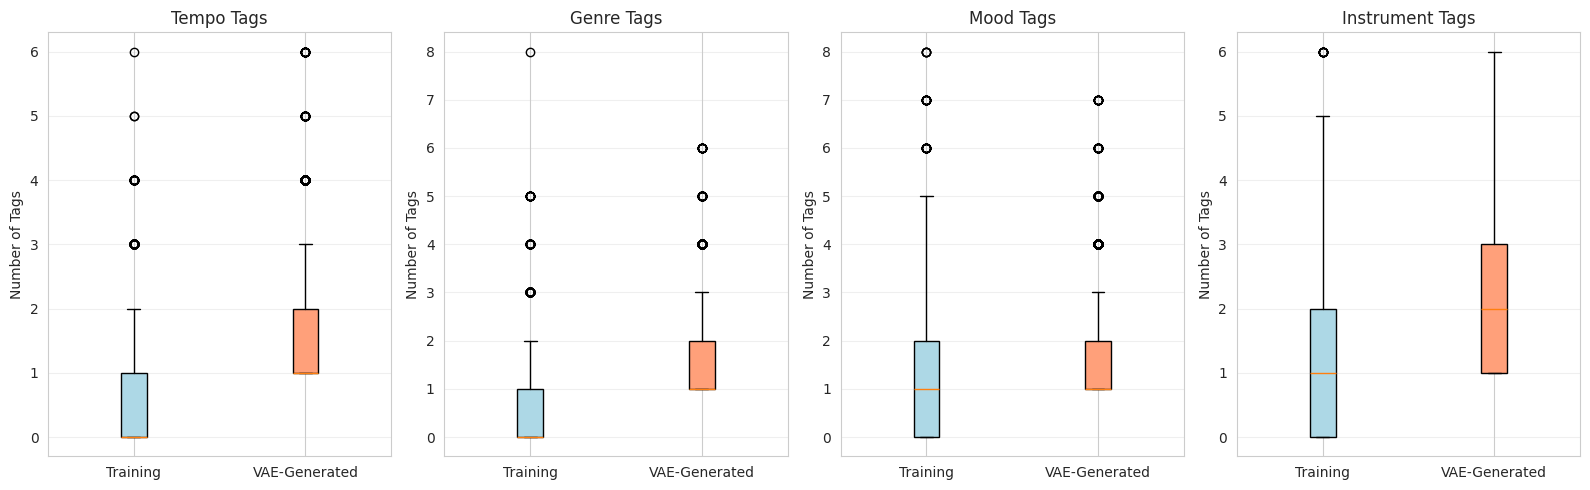

Box plot comparison created successfully


In [12]:

# Create box plots for detailed distribution comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for idx, (cat_name, col) in enumerate(tag_categories.items()):
    ax = axes[idx]
    
    train_counts = df_mc[col].apply(len)
    vae_counts = df_vae_all[col].apply(len)
    
    data_to_plot = [train_counts, vae_counts]
    bp = ax.boxplot(data_to_plot, labels=['Training', 'VAE-Generated'], patch_artist=True)
    
    # Color the boxes
    colors = ['lightblue', 'lightsalmon']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel('Number of Tags')
    ax.set_title(f'{cat_name} Tags')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Box plot comparison created successfully")


## Analyze Tag Correlation Matrices


In [13]:

# Compute correlation matrices
train_tag_counts = pd.DataFrame({
    'Tempo': df_mc['tempo_tags'].apply(len),
    'Genre': df_mc['genre_tags'].apply(len),
    'Mood': df_mc['mood_tags'].apply(len),
    'Instrument': df_mc['instrument_tags'].apply(len)
})

vae_tag_counts = pd.DataFrame({
    'Tempo': df_vae_baseline['tempo_tags'].apply(len),
    'Genre': df_vae_baseline['genre_tags'].apply(len),
    'Mood': df_vae_baseline['mood_tags'].apply(len),
    'Instrument': df_vae_baseline['instrument_tags'].apply(len)
})

train_corr = train_tag_counts.corr()
vae_corr = vae_tag_counts.corr()

print("\n" + "="*100)
print("CORRELATION MATRIX - TRAINING DATASET")
print("="*100)
print(train_corr.round(3))

print("\n" + "="*100)
print("CORRELATION MATRIX - VAE-GENERATED DATASET")
print("="*100)
print(vae_corr.round(3))

print("\n" + "="*100)
print("CORRELATION DIFFERENCE (VAE - Training)")
print("="*100)
print((vae_corr - train_corr).round(3))



CORRELATION MATRIX - TRAINING DATASET
            Tempo  Genre   Mood  Instrument
Tempo       1.000  0.181  0.115       0.127
Genre       0.181  1.000  0.143       0.051
Mood        0.115  0.143  1.000      -0.005
Instrument  0.127  0.051 -0.005       1.000

CORRELATION MATRIX - VAE-GENERATED DATASET
            Tempo  Genre   Mood  Instrument
Tempo       1.000  0.077  0.056      -0.066
Genre       0.077  1.000  0.393      -0.067
Mood        0.056  0.393  1.000      -0.093
Instrument -0.066 -0.067 -0.093       1.000

CORRELATION DIFFERENCE (VAE - Training)
            Tempo  Genre   Mood  Instrument
Tempo       0.000 -0.103 -0.059      -0.193
Genre      -0.103  0.000  0.250      -0.118
Mood       -0.059  0.250  0.000      -0.088
Instrument -0.193 -0.118 -0.088       0.000


## Visualize Distribution Differences


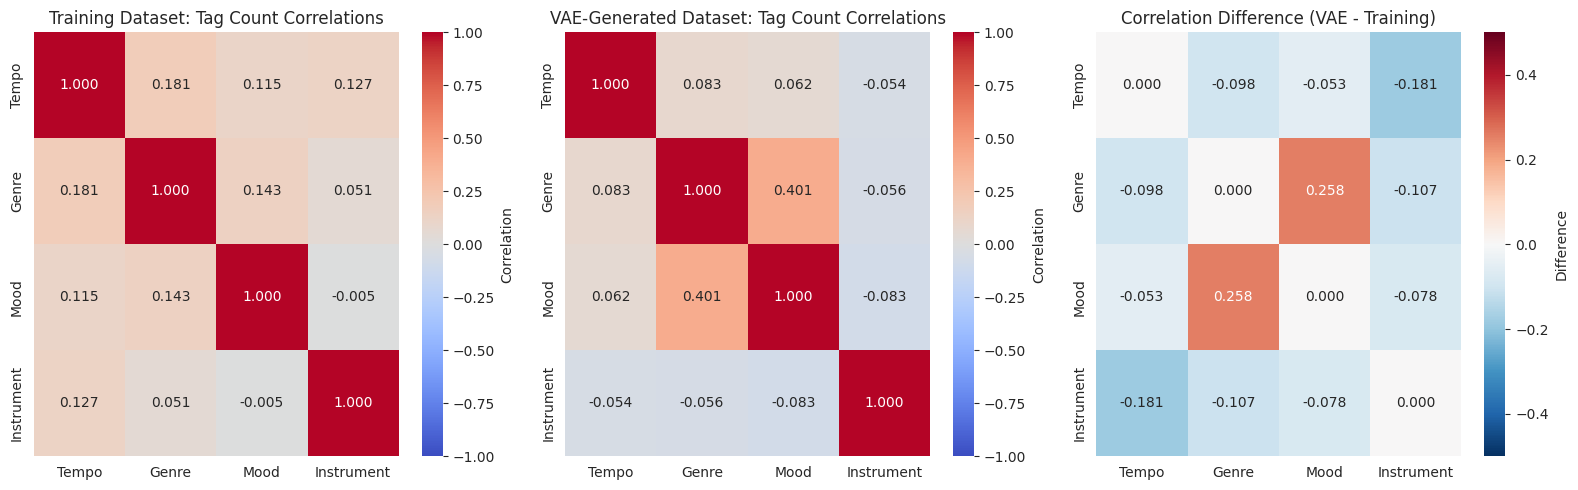

Correlation heatmaps created successfully


In [14]:

# Create correlation heatmaps side-by-side
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Training dataset correlation
sns.heatmap(train_corr, annot=True, fmt='.3f', cmap='coolwarm', vmin=-1, vmax=1, 
            ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Training Dataset: Tag Count Correlations')

# VAE-generated dataset correlation
sns.heatmap(vae_corr, annot=True, fmt='.3f', cmap='coolwarm', vmin=-1, vmax=1,
            ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('VAE-Generated Dataset: Tag Count Correlations')

# Difference
sns.heatmap(vae_corr - train_corr, annot=True, fmt='.3f', cmap='RdBu_r', vmin=-0.5, vmax=0.5,
            ax=axes[2], cbar_kws={'label': 'Difference'})
axes[2].set_title('Correlation Difference (VAE - Training)')

plt.tight_layout()
plt.show()

print("Correlation heatmaps created successfully")


## Temperature Analysis

Analyze how different temperature values in the VAE affect tag generation quality and distribution stability.

In [15]:
# Analyze individual tag occurrences across different temperatures
temperatures = sorted(df_vae['temperature'].unique())

print("\n" + "="*120)
print("TEMPERATURE ANALYSIS - INDIVIDUAL TAG OCCURRENCE PATTERNS")
print("="*120)
print(f"\nAvailable temperatures: {temperatures}")
print(f"Number of samples per temperature: {df_vae.groupby('temperature').size().to_dict()}")

# Collect tag occurrence patterns across temperatures
tag_temperature_patterns = {}

for cat_name, col_name in categories_to_compare:
    # Get training reference counts
    train_tags = get_all_tags(df_mc, col_name)
    train_counter = Counter(train_tags)
    train_total = len(train_tags)
    
    # Collect per-tag statistics across temperatures
    tag_data = {}
    
    for temp in temperatures:
        df_vae_temp = df_vae[df_vae['temperature'] == temp].reset_index(drop=True)
        vae_tags = get_all_tags(df_vae_temp, col_name)
        vae_counter = Counter(vae_tags)
        vae_total = len(vae_tags)
        
        for tag in set(train_counter.keys()) | set(vae_counter.keys()):
            if tag not in tag_data:
                tag_data[tag] = {
                    'training_count': train_counter.get(tag, 0),
                    'training_pct': (train_counter.get(tag, 0) / train_total * 100) if train_total > 0 else 0,
                }
            
            vae_count = vae_counter.get(tag, 0)
            vae_pct = (vae_count / vae_total * 100) if vae_total > 0 else 0
            tag_data[tag][f'temp_{temp}_count'] = vae_count
            tag_data[tag][f'temp_{temp}_pct'] = vae_pct
    
    # Convert to DataFrame for analysis
    tag_df = pd.DataFrame(tag_data).T.reset_index()
    tag_df.columns = ['Tag'] + list(tag_df.columns[1:])
    
    tag_temperature_patterns[cat_name] = tag_df
    
    # Calculate correlations between temperatures and training
    print(f"\n{'='*100}")
    print(f"{cat_name.upper()} - INDIVIDUAL TAG ANALYSIS ACROSS TEMPERATURES")
    print(f"{'='*100}")
    
    # Show tags that vary most across temperatures
    temp_cols = [f'temp_{t}_pct' for t in temperatures]
    tag_df['temp_std'] = tag_df[temp_cols].std(axis=1)
    tag_df['temp_range'] = tag_df[temp_cols].max(axis=1) - tag_df[temp_cols].min(axis=1)
    tag_df['corr_with_training'] = tag_df[temp_cols].corrwith(tag_df['training_pct'], axis=0)
    
    # Sort by temperature variability
    high_variability = tag_df.nlargest(10, 'temp_range')[['Tag', 'training_pct'] + temp_cols + ['temp_range', 'temp_std']]
    print(f"\nTop 10 tags with HIGHEST variability across temperatures:")
    print(high_variability.to_string(index=False))
    
    # Sort by lowest variability (consistent across temperatures)
    low_variability = tag_df[tag_df['temp_range'] > 0].nsmallest(10, 'temp_range')[['Tag', 'training_pct'] + temp_cols + ['temp_range']]
    print(f"\nTop 10 tags with LOWEST variability across temperatures:")
    print(low_variability.to_string(index=False))


TEMPERATURE ANALYSIS - INDIVIDUAL TAG OCCURRENCE PATTERNS

Available temperatures: [0.8, 1.0, 1.25, 1.5, 1.75]
Number of samples per temperature: {0.8: 2004, 1.0: 1941, 1.25: 1900, 1.5: 1871, 1.75: 1854}

GENRE - INDIVIDUAL TAG ANALYSIS ACROSS TEMPERATURES

Top 10 tags with HIGHEST variability across temperatures:
             Tag  training_pct  temp_0.8_pct  temp_1.0_pct  temp_1.25_pct  temp_1.5_pct  temp_1.75_pct  temp_range  temp_std
             pop      7.171171     13.369369     12.887740      12.322097     13.201821      11.578143    1.791226  0.730160
            rock      7.459459      8.540541      8.936484       7.902622      7.701062       8.215514    1.235422  0.494581
       folk song      1.513514      2.846847      2.437223       2.434457      1.669196       2.292702    1.177651  0.426441
     movie music      1.261261      2.954955      3.175775       2.808989      2.996965       3.935804    1.126816  0.445226
       classical      4.000000      9.981982      9.010340

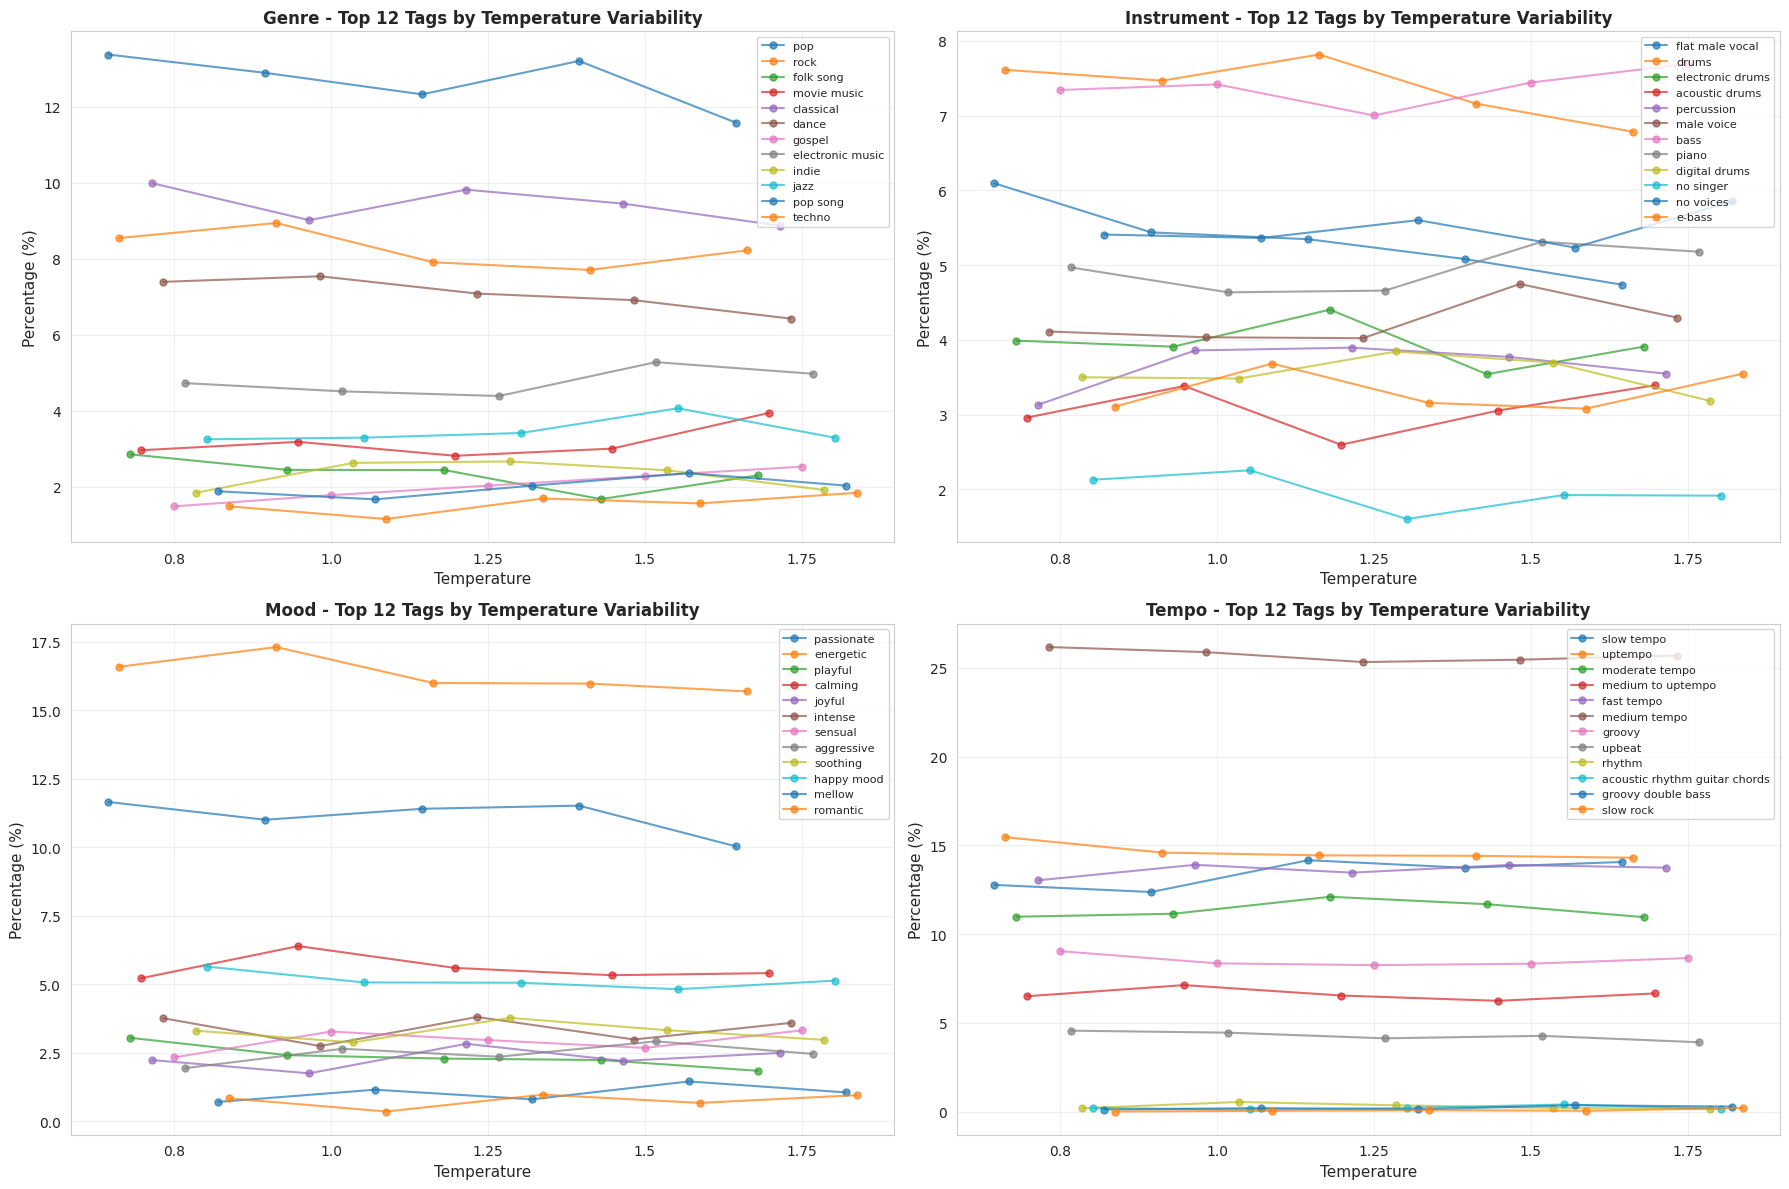

Tag occurrence patterns across temperatures visualization created successfully


In [16]:
# Create visualizations showing tag behavior across temperatures
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    tag_df = tag_temperature_patterns[cat_name]
    
    # Select top 12 tags by temperature variability
    top_variable_tags = tag_df.nlargest(12, 'temp_range')
    
    temp_cols = [f'temp_{t}_pct' for t in temperatures]
    x = np.arange(len(temperatures))
    width = 0.07
    
    # Plot training reference as a horizontal line
    for idx_tag, (_, row) in enumerate(top_variable_tags.iterrows()):
        offset = (idx_tag - len(top_variable_tags)/2) * width
        values = [row[col] for col in temp_cols]
        ax.plot(x + offset, values, marker='o', linewidth=1.5, markersize=5, label=row['Tag'], alpha=0.7)
    
    ax.set_xlabel('Temperature', fontsize=11)
    ax.set_ylabel('Percentage (%)', fontsize=11)
    ax.set_title(f'{cat_name} - Top 12 Tags by Temperature Variability', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{t}' for t in temperatures])
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Tag occurrence patterns across temperatures visualization created successfully")


In [17]:
# Analyze which tags favor lower vs higher temperatures
print("\n" + "="*120)
print("TAG PREFERENCE ANALYSIS - LOWER vs HIGHER TEMPERATURES")
print("="*120)

low_temp = temperatures[0]
high_temp = temperatures[-1]

for cat_name, _ in categories_to_compare:
    tag_df = tag_temperature_patterns[cat_name]
    
    # Calculate average percentage at low and high temperatures
    low_temp_col = f'temp_{low_temp}_pct'
    high_temp_col = f'temp_{high_temp}_pct'
    
    tag_df['low_temp_pct'] = tag_df[low_temp_col]
    tag_df['high_temp_pct'] = tag_df[high_temp_col]
    tag_df['temp_preference'] = tag_df['high_temp_pct'] - tag_df['low_temp_pct']
    
    print(f"\n{'='*100}")
    print(f"{cat_name.upper()} - TAG PREFERENCES ({low_temp} vs {high_temp})")
    print(f"{'='*100}")
    
    # Tags that appear more at HIGH temperature
    high_pref = tag_df.nlargest(10, 'temp_preference')[['Tag', 'training_pct', low_temp_col, high_temp_col, 'temp_preference']]
    print(f"\nTags that INCREASE at HIGHER temperature:")
    print(high_pref.to_string(index=False))
    
    # Tags that appear more at LOW temperature
    low_pref = tag_df.nsmallest(10, 'temp_preference')[['Tag', 'training_pct', low_temp_col, high_temp_col, 'temp_preference']]
    print(f"\nTags that DECREASE at HIGHER temperature (prefer LOWER temp):")
    print(low_pref.to_string(index=False))
    
    # Calculate correlation between each tag's pattern and training
    print(f"\nTag occurrence patterns vs Training dataset:")
    corr_summary = []
    for _, row in tag_df.iterrows():
        training_val = row['training_pct']
        temp_vals = [row[f'temp_{t}_pct'] for t in temperatures]
        if len(set(temp_vals)) > 0:  # Only if there's variation
            corr_summary.append({
                'Tag': row['Tag'],
                'Training %': training_val,
                'Mean VAE %': np.mean(temp_vals),
                '% Diff from Training': np.mean(temp_vals) - training_val,
                'Variability': np.std(temp_vals)
            })
    
    corr_df = pd.DataFrame(corr_summary).sort_values('% Diff from Training', ascending=False)
    print(f"\nTags with largest deviations from training:")
    print(corr_df.head(10).to_string(index=False))



TAG PREFERENCE ANALYSIS - LOWER vs HIGHER TEMPERATURES

GENRE - TAG PREFERENCES (0.8 vs 1.75)

Tags that INCREASE at HIGHER temperature:
             Tag  training_pct  temp_0.8_pct  temp_1.75_pct  temp_preference
          gospel      1.369369      1.477477       2.521972         1.044494
     movie music      1.261261      2.954955       3.935804         0.980849
   country music      1.621622      0.180180       0.611387         0.431207
         country      1.189189      0.900901       1.260986         0.360085
          techno      1.549550      1.477477       1.834161         0.356684
          reggae      1.945946      0.756757       1.108139         0.351382
         ambient      2.882883      3.135135       3.477264         0.342129
      electronic      1.261261      4.756757       5.043943         0.287187
electronic music      4.828829      4.720721       4.967520         0.246799
      rock music      1.297297      1.117117       1.337409         0.220292

Tags that DECR

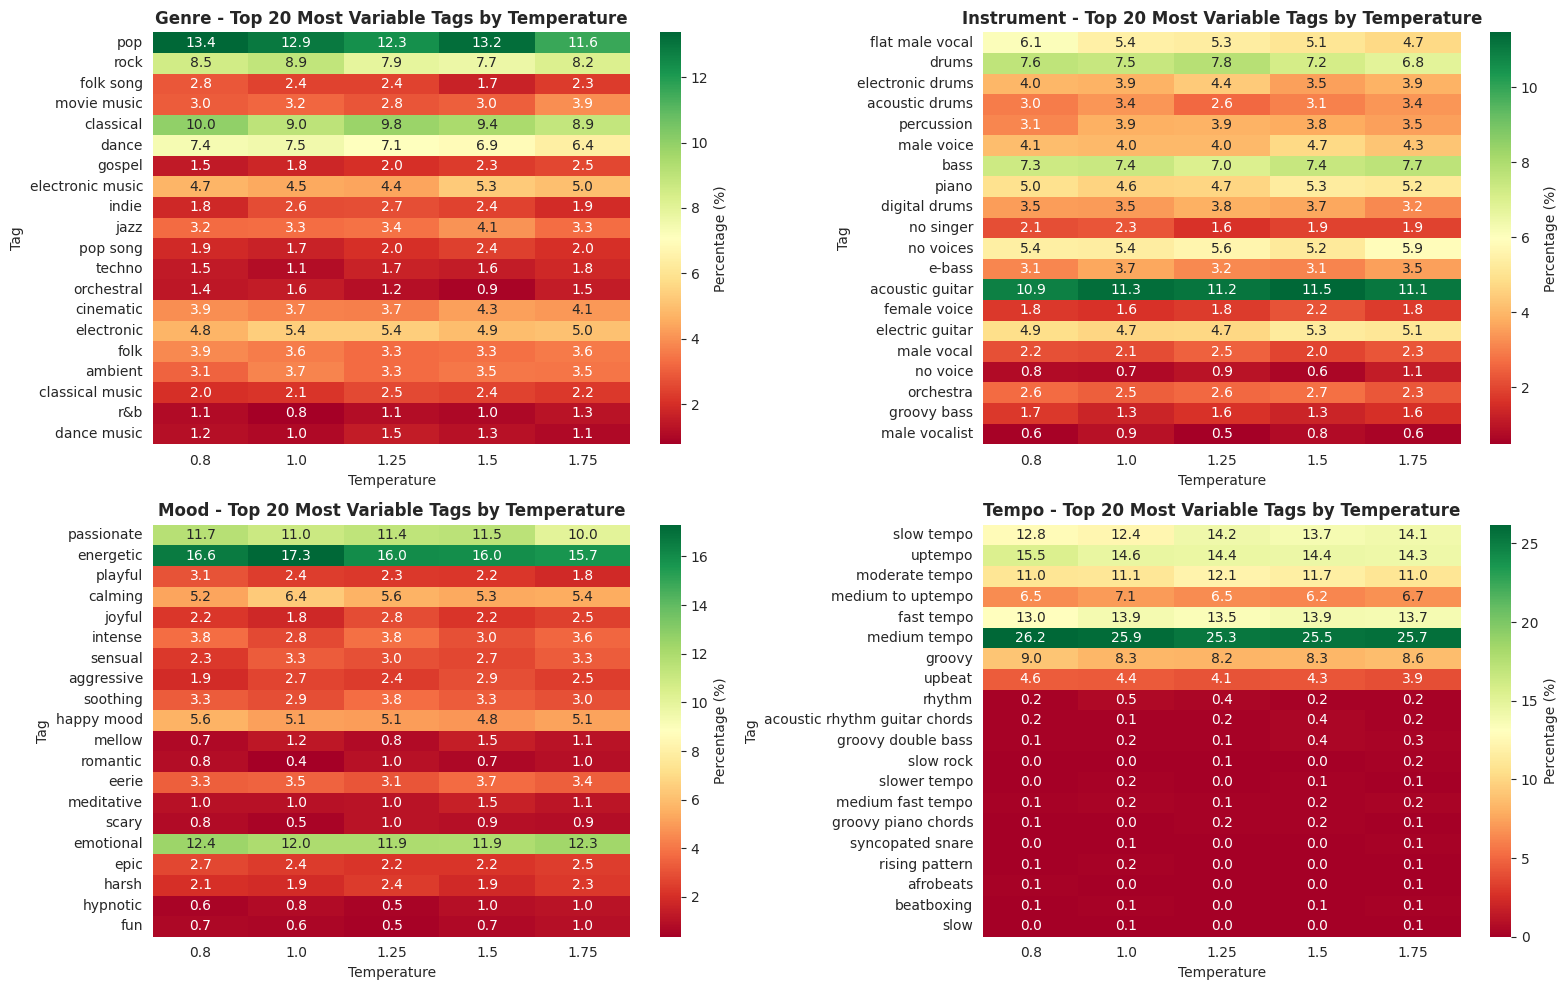

Tag occurrence heatmaps across temperatures created successfully


In [18]:
# Create heatmaps showing tag occurrence patterns across temperatures
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    tag_df = tag_temperature_patterns[cat_name]
    
    # Select top 20 most variable tags
    top_tags = tag_df.nlargest(20, 'temp_range')
    
    # Create matrix: rows = tags, columns = temperatures
    temp_cols = [f'temp_{t}_pct' for t in temperatures]
    heatmap_data = top_tags[['Tag'] + temp_cols].set_index('Tag')[temp_cols].values
    
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax,
                xticklabels=[f'{t}' for t in temperatures],
                yticklabels=top_tags['Tag'].values,
                cbar_kws={'label': 'Percentage (%)'})
    ax.set_title(f'{cat_name} - Top 20 Most Variable Tags by Temperature', fontsize=12, fontweight='bold')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Tag')

plt.tight_layout()
plt.show()

print("Tag occurrence heatmaps across temperatures created successfully")



POPULARITY ANALYSIS - MOST vs LEAST POPULAR TAGS ACROSS TEMPERATURES

GENRE - POPULARITY DYNAMICS

Most Popular Tags in Training (% change from low to high temp):
  rock                :   7.46% (train) →   8.54% (0.8°) →   8.22% (1.75°) | Change: -0.33%
  pop                 :   7.17% (train) →  13.37% (0.8°) →  11.58% (1.75°) | Change: -1.79%
  electronic music    :   4.83% (train) →   4.72% (0.8°) →   4.97% (1.75°) | Change: +0.25%
  dance music         :   4.54% (train) →   1.19% (0.8°) →   1.07% (1.75°) | Change: -0.12%
  classical           :   4.00% (train) →   9.98% (0.8°) →   8.87% (1.75°) | Change: -1.12%

Least Popular Tags in Training (% change from low to high temp):
  dance pop           :   0.86% (train) →   0.00% (0.8°) →   0.00% (1.75°) | Change: +0.00%
  ambient noises      :   0.83% (train) →   0.14% (0.8°) →   0.08% (1.75°) | Change: -0.07%
  rapping             :   0.83% (train) →   1.01% (0.8°) →   0.61% (1.75°) | Change: -0.40%
  house               :   0.61% (t

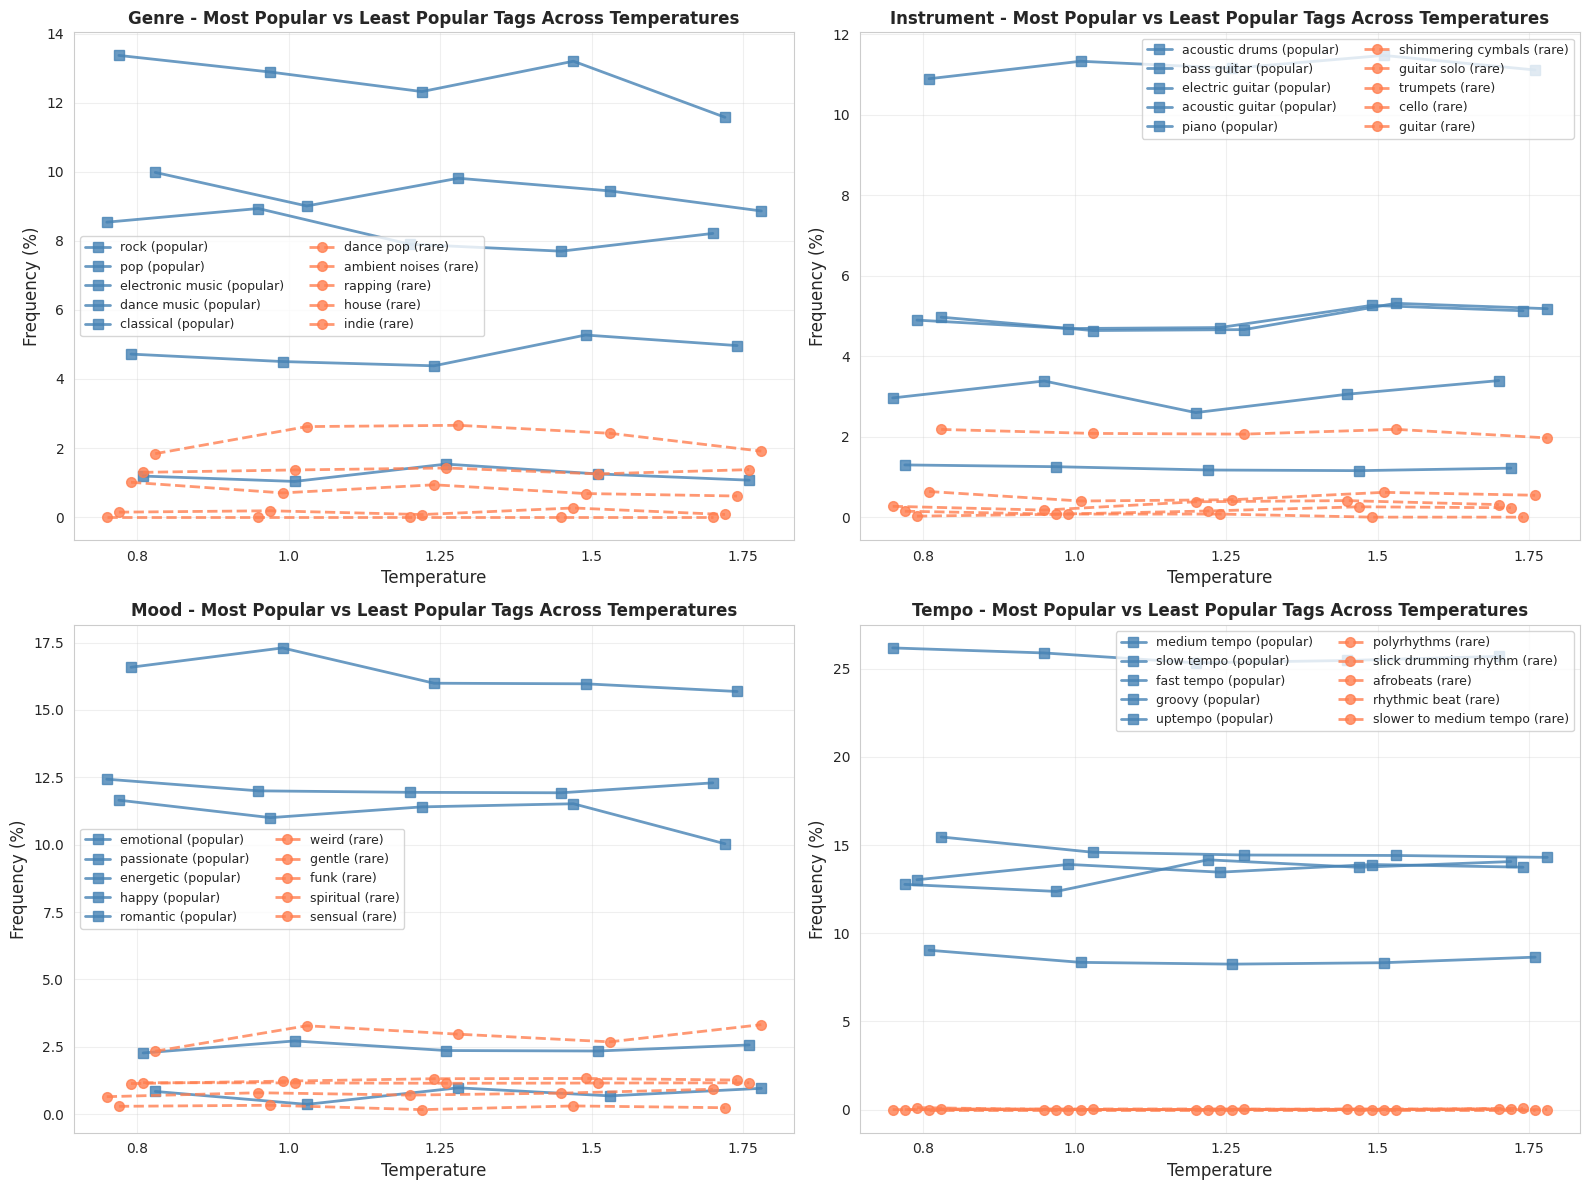


Popularity dynamics across temperatures visualization created successfully


In [19]:
# Analyze how popular vs unpopular tags change with temperature
print("\n" + "="*120)
print("POPULARITY ANALYSIS - MOST vs LEAST POPULAR TAGS ACROSS TEMPERATURES")
print("="*120)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    tag_df = tag_temperature_patterns[cat_name]
    
    # Identify most and least popular tags in training dataset
    tag_df_sorted = tag_df.sort_values('training_pct', ascending=False)
    
    num_tags = 5
    most_popular = tag_df_sorted.head(num_tags)
    least_popular = tag_df_sorted.tail(num_tags)
    
    # Collect temperature values
    temp_cols = [f'temp_{t}_pct' for t in temperatures]
    x = np.arange(len(temperatures))
    width = 0.08
    
    # Plot most popular tags
    for idx_tag, (_, row) in enumerate(most_popular.iterrows()):
        offset = (idx_tag - num_tags/2) * width
        values = [row[col] for col in temp_cols]
        ax.plot(x + offset, values, marker='s', linewidth=2, markersize=7, 
                label=f"{row['Tag']} (popular)", alpha=0.8, color='steelblue')
    
    # Plot least popular tags
    for idx_tag, (_, row) in enumerate(least_popular.iterrows()):
        offset = (idx_tag - num_tags/2) * width
        values = [row[col] for col in temp_cols]
        ax.plot(x + offset, values, marker='o', linewidth=2, markersize=7, 
                label=f"{row['Tag']} (rare)", alpha=0.8, color='coral', linestyle='--')
    
    ax.set_xlabel('Temperature', fontsize=12)
    ax.set_ylabel('Frequency (%)', fontsize=12)
    ax.set_title(f'{cat_name} - Most Popular vs Least Popular Tags Across Temperatures', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{t}' for t in temperatures])
    ax.legend(fontsize=9, loc='best', ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Print analysis
    print(f"\n{'='*100}")
    print(f"{cat_name.upper()} - POPULARITY DYNAMICS")
    print(f"{'='*100}")
    
    print(f"\nMost Popular Tags in Training (% change from low to high temp):")
    for _, row in most_popular.iterrows():
        low_pct = row[f'temp_{low_temp}_pct']
        high_pct = row[f'temp_{high_temp}_pct']
        change = high_pct - low_pct
        print(f"  {row['Tag']:20s}: {row['training_pct']:6.2f}% (train) → {low_pct:6.2f}% ({low_temp}°) → {high_pct:6.2f}% ({high_temp}°) | Change: {change:+.2f}%")
    
    print(f"\nLeast Popular Tags in Training (% change from low to high temp):")
    for _, row in least_popular.iterrows():
        low_pct = row[f'temp_{low_temp}_pct']
        high_pct = row[f'temp_{high_temp}_pct']
        change = high_pct - low_pct
        print(f"  {row['Tag']:20s}: {row['training_pct']:6.2f}% (train) → {low_pct:6.2f}% ({low_temp}°) → {high_pct:6.2f}% ({high_temp}°) | Change: {change:+.2f}%")

plt.tight_layout()
plt.show()

print("\nPopularity dynamics across temperatures visualization created successfully")
